# FFT-Based Image Shift Estimation Test

This notebook demonstrates phase correlation Fourier methods to estimate rigid translational shifts between two grayscale images. A synthetic test image is generated with a small, elongated horizontal rectangle embedded in a uniform field, and then shifted using `scipy.ndimage.shift`. 

Gaussian noise is added to simulate realistic conditions. The core function, `fftFlowVector`, computes the shift between the original and shifted images using cross powerspectrum and phase correlation. 

 The shift vector is printed in `[y, x]` pixel units due to internal operations respect the NumPy array convention `(row, col)`.
This should work well as lonf as the objects are mostly rigid.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage


In [21]:


def fftFlowVector(im1, im2, global_shift=True):
    """ Estimates flow vectors in two images using cross covariance. """
    if not global_shift and (np.max(im1) == 0 or np.max(im2) == 0):
        return None

    crosscov = fftCrossCov(im1, im2)
    sigma = 3
    cov_smooth = ndimage.filters.gaussian_filter(crosscov, sigma)
    dims = np.array(im1.shape)

    pshift = np.argwhere(cov_smooth == np.max(cov_smooth))[0]
    
    rs = np.ceil(dims[0]/2).astype('int')
    cs = np.ceil(dims[1]/2).astype('int')

    # Calculate shift relative to center - see fft_shift.
    pshift = pshift - (dims - [rs, cs])
    return pshift


def fftCrossCov(im1, im2):
    """ Computes cross correlation matrix using FFT method. """
    fft1_conj = np.conj(np.fft.fft2(im1))
    fft2 = np.fft.fft2(im2)
    normalize = abs(fft2 * fft1_conj)
    try:  min_value = normalize[(normalize > 0)].min()
    except ValueError:  #raised if empty.
       min_value=0.01
       pass  
    normalize[normalize == 0] = min_value  # prevent divide by zero error
    cross_power_spectrum = (fft2 * fft1_conj)/normalize
    crosscov = np.fft.ifft2(cross_power_spectrum)
    crosscov = np.real(crosscov)
    return motionVector(crosscov)


def motionVector(fft_mat):
    """ Rearranges the cross correlation matrix so that 'zero' frequency or DC
    component is in the middle of the matrix. Taken from stackoverflow Que.
    30630632.
    """
    if type(fft_mat) is np.ndarray:
        rs = np.ceil(fft_mat.shape[0]/2).astype('int')
        cs = np.ceil(fft_mat.shape[1]/2).astype('int')
        quad1 = fft_mat[:rs, :cs]
        quad2 = fft_mat[:rs, cs:]
        quad3 = fft_mat[rs:, cs:]
        quad4 = fft_mat[rs:, :cs]
        centered_t = np.concatenate((quad4, quad1), axis=0)
        centered_b = np.concatenate((quad3, quad2), axis=0)
        centered = np.concatenate((centered_b, centered_t), axis=1)
        # Thus center is formed by shifting the entries of fft_mat
        # up/left by [rs, cs] indices, or equivalently down/right by
        # (fft_mat.shape - [rs, cs]) indices, with edges wrapping. 
        return centered
    else:
        print('input to motionVector() should be a matrix')
        return

In [30]:
def load_and_shift_image(shift=(5, 10), size=(256, 256)):
    """Create a synthetic image, add noise, and shift it using numpy."""
    image = np.ones(size, dtype=np.float32)*100
    # Create a small, highly elongated rectangle
    r_start = size[0] // 2 - 4
    r_end = size[0] // 2 + 4
    c_start = size[1] // 4
    c_end = 3 * size[1] // 4
    image[r_start:r_end, c_start:c_end] = 112
    image += np.random.normal(loc=50, scale=0.5, size=size).astype(np.float32)
    shifted = ndimage.shift(image, shift=shift, order=1, mode='wrap')
    shifted += np.random.normal(loc=0.0, scale=0.05, size=size).astype(np.float32)
    return image, shifted


def display_images(im1, im2, shift):
    """Visualizes the original and shifted images."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(im1, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(im2, cmap='gray')
    ax[1].set_title(f'Shifted Image by {shift}')
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()


def test_fft_flow_vector():
    """Test routine for fftFlowVector with known translation."""
    true_shift = (5, 10)  # (row, col)
    im1, im2 = load_and_shift_image(shift=true_shift)
    estimated_shift = fftFlowVector(im1, im2)

    print(f"True shift: {true_shift} [px]")  # x, y order for display
    print(f"Estimated shift: {estimated_shift} [px]")

    display_images(im1, im2, true_shift)




True shift: (5, 10) [px]
Estimated shift: [ 5 10] [px]


/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_53369/1606926561.py:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  cov_smooth = ndimage.filters.gaussian_filter(crosscov, sigma)


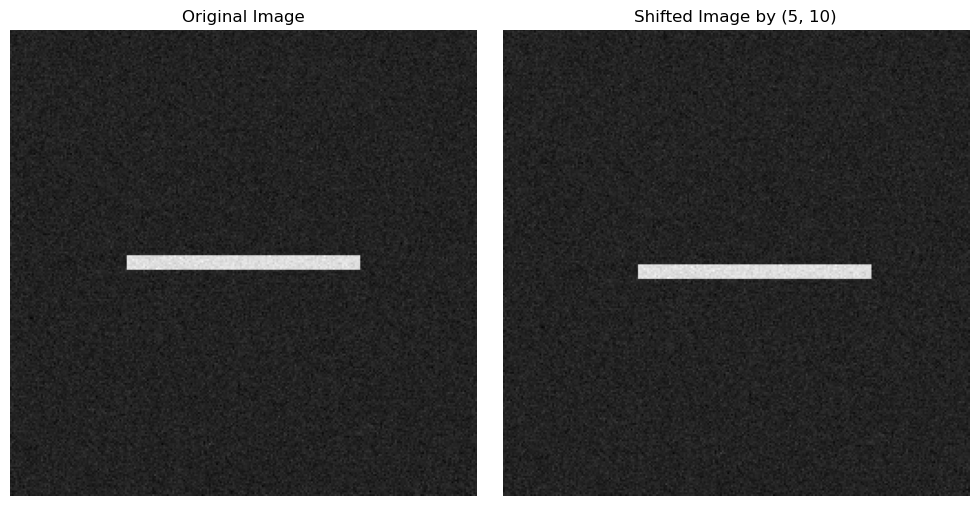

In [31]:

if __name__ == '__main__':
    test_fft_flow_vector()